# Poonen-Rains heuristics

This notebook verifies Poonen-Rains conjectures and results regarding probability mass function and moments. 

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

pq_file = "three_mil_2selmer.parquet"
hb_columns = ['n','2selmer_rank', 'mod8']

table = pq.read_table(pq_file, columns=hb_columns)

# Convert the PyArrow Table to a Pandas DataFrame
df = table.to_pandas()
df['size'] = 2 ** (df['2selmer_rank']-2)
#odd_df =  df[df['mod8'].isin([1,3,5,7])].drop(columns=['2selmer_rank'])
#odd_df['group'] = odd_df['mod8'].map(lambda x: '1_3' if x in [1, 3] else '5_7')

df

,n,2selmer_rank,mod8,size
0,1,2,1,1
1,2,2,2,1
2,3,2,3,1
3,5,3,5,2
4,6,3,6,2
...,...,...,...,...
1823768,2999991,3,7,2
1823769,2999993,4,1,4
1823770,2999995,4,3,4
1823771,2999998,3,6,2


Computation of Empirical Moments

In [2]:
for k in [1, 2, 3, 4, 5]:
    moment = (df['size'] ** k).mean()
    print(f"Empirical {k}-th moment of 2-Selmer rank: {moment:.5f}")

Empirical 1-th moment of 2-Selmer rank: 2.86956
Empirical 2-th moment of 2-Selmer rank: 14.41419
Empirical 3-th moment of 2-Selmer rank: 138.14674
Empirical 4-th moment of 2-Selmer rank: 2475.49666
Empirical 5-th moment of 2-Selmer rank: 74670.29928


**S2r	Poonen–Rains Probability**

0	   0.2097
1	   0.4194
2	   0.2796
3	   0.0787
4	   0.0121

Plotting Empirical vs. Theoretical PMF

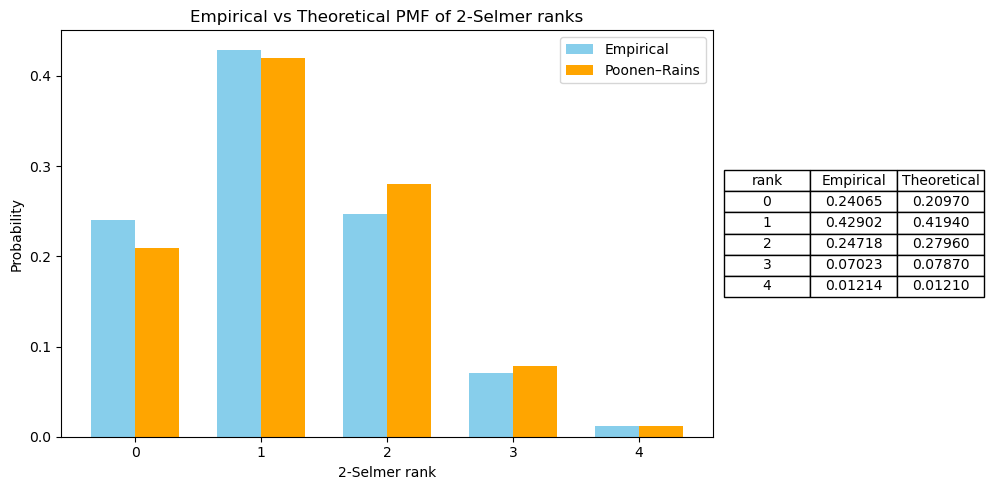

In [27]:
from matplotlib.gridspec import GridSpec

empirical_pmf = (df['2selmer_rank']-2).value_counts(normalize=True).sort_index()
#print("Empirical PMF of 2-Selmer Rank:")
#print(empirical_pmf)

# Truncate to common support (up to 4 or 5 is usually enough)
max_rank = min(empirical_pmf.index.max(), 4)
ranks = list(range(0, max_rank + 1))

# Fill in missing empirical probabilities with 0
empirical_probs = [empirical_pmf.get(r, 0) for r in ranks]

#print(empirical_probs)


# Theoretical Poonen–Rains probabilities (normalized for first 5 ranks)
poonen_rains_pmf = {
    0: 0.2097,
    1: 0.4194,
    2: 0.2796,
    3: 0.0787,
    4: 0.0121
}
theoretical_probs = [poonen_rains_pmf.get(r, 0) for r in ranks]



# Create grid layout: 1 row, 2 columns (bar chart + table)
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[3, 1])
bar_width = 0.35
x = range(len(ranks))

# --- Left: Bar Chart ---
ax1 = fig.add_subplot(gs[0])

bars1 = plt.bar([i - bar_width/2 for i in x], empirical_probs, width=bar_width, label="Empirical", color='skyblue')
bars2 = plt.bar([i + bar_width/2 for i in x], theoretical_probs, width=bar_width, label="Poonen–Rains", color='orange')
#bars1 = ax1.bar(ks - width/2, empirical_probs, width=bar_width, label='Empirical', color='skyblue')
#bars2 = ax1.bar(ks + width/2, theoretical_probs, width, label='Poonen–Rains', color='orange')

ax1.set_xlabel("2-Selmer rank")
ax1.set_ylabel("Probability")
ax1.set_title("Empirical vs Theoretical PMF of 2-Selmer ranks")
ax1.set_xticks(x)
#ax1.set_xticklabels([f'$k={k}$' for k in ks])
ax1.legend()

# --- Right: Table ---
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Hide axis

# Build table data
cell_text = []
for i, k in enumerate(x):
    cell_text.append([f'${k}$', f'{empirical_probs[i]:.5f}', f'{theoretical_probs[i]:.5f}'])

# Draw table
table = ax2.table(
    cellText=cell_text,
    colLabels=["rank", "Empirical", "Theoretical"],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.tight_layout()
plt.savefig("prpmf.jpeg")
plt.show()

**Total Variation Distance (TVD)**

To quantify the match, use the total variation distance between the empirical and theoretical distributions: A small TVD (e.g., < 0.1) suggests strong agreement with theory.

In [4]:
tvd = 0.5 * sum(abs(emp - theo) for emp, theo in zip(empirical_probs, theoretical_probs))
print(f"Total Variation Distance (TVD): {tvd:.4f}")

Total Variation Distance (TVD): 0.0411


Moment          Empirical    Theoretical
E[r^1]           2.869564       3.006100
E[r^2]          14.414192      15.007300
E[r^3]         138.146738     127.699300
E[r^4]        2475.496656    1718.126500


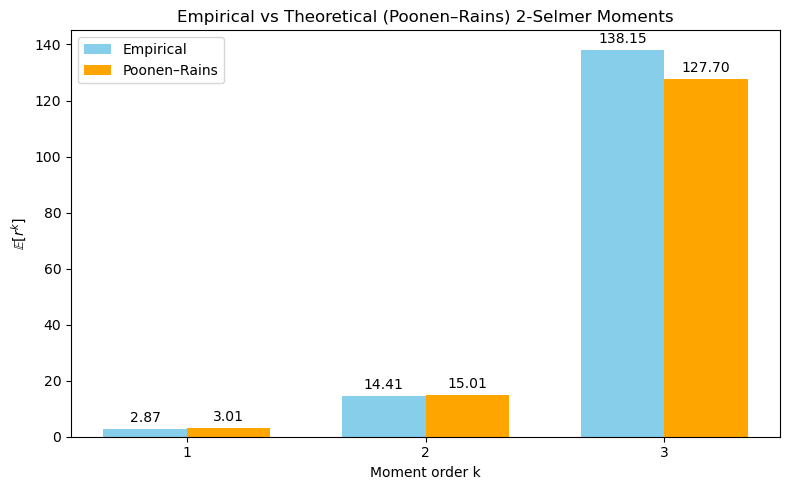

In [28]:
#import pandas as pd
import numpy as np


# Step 1: Compute empirical moments
empirical_moments = {}

for k in range(1, 5):
    empirical_moments[k] = ((df['size']) ** k).mean()

# Step 2: Define Poonen–Rains PMF (truncated at rank 5)
poonen_rains_pmf = { 0: 0.2097,  1: 0.4194,   2: 0.2796,  3: 0.0787,  4: 0.0121,  5: 0.0005 }

# Step 3: Compute theoretical moments
theoretical_moments = {}
for k in range(1, 5):
    moment = sum((2 ** (r*k)) * prob for r, prob in poonen_rains_pmf.items())
    theoretical_moments[k] = moment

# Step 4: Print comparison
print(f"{'Moment':<10}{'Empirical':>15}{'Theoretical':>15}")
for k in range(1, 5):
    print(f"{'E[r^'+str(k)+']':<10}{empirical_moments[k]:>15.6f}{theoretical_moments[k]:>15.6f}")

#df

ks = np.arange(1,4)

empirical_vals = [empirical_moments[k] for k in ks]
theoretical_vals = [theoretical_moments[k] for k in ks]
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(ks - width/2, empirical_vals, width, label='Empirical', color='skyblue')
bars2 = ax.bar(ks + width/2, theoretical_vals, width, label='Poonen–Rains', color='orange')
ax.set_xlabel("Moment order k")
ax.set_ylabel(r"$\mathbb{E}[r^k]$")
ax.set_title("Empirical vs Theoretical (Poonen–Rains) 2-Selmer Moments")
ax.set_xticks(ks)
ax.legend()
# Optional: Add values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.tight_layout()
plt.savefig("prmoments.jpeg")
plt.show()

The plot of the abvove comparison

Empirical Moments vs. number growth

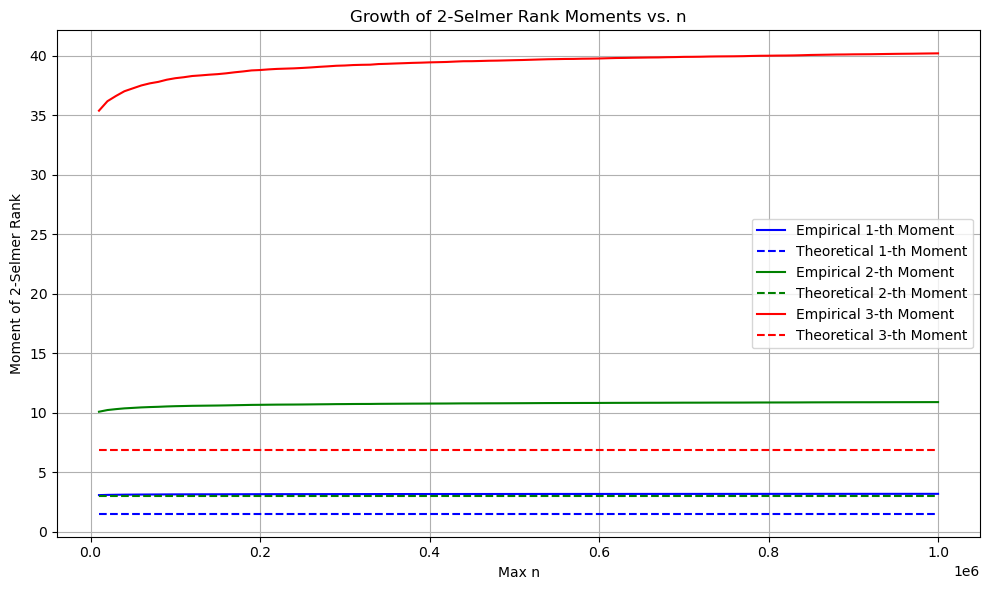

In [18]:
import numpy as np

# Define sample points X (increasing values of n)
X_values = np.linspace(10000, 1_000_000, 100, dtype=int)

# Choose which moments to compute
moment_orders = [1, 2, 3]
moment_data = {k: [] for k in moment_orders}

# Compute moments up to each X
for X in X_values:
    subset = df[df['n'] <= X]
    for k in moment_orders:
        moment_k = ((subset['2selmer_rank']) ** k).mean()
        moment_data[k].append(moment_k)
    #print(moment_data[1])

# Plot each moment
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
theoretical_moments = {
    1: 1.5,
    2: 3.0,
    3: 6.875  # From Poonen–Rains model for 2-Selmer RECHECK VALUES
}

for i, k in enumerate(moment_orders):
    plt.plot(X_values, moment_data[k], label=f"Empirical {k}-th Moment", color=colors[i])
    if k in theoretical_moments:
        plt.hlines(theoretical_moments[k], X_values[0], X_values[-1], 
                   color=colors[i], linestyle='--', label=f"Theoretical {k}-th Moment")

plt.title("Growth of 2-Selmer Rank Moments vs. n")
plt.xlabel("Max n")
plt.ylabel("Moment of 2-Selmer Rank")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Log log plot of the Moment growth

In [ ]:
# Binning thresholds
X_vals = [10**3, 10**4, 10**5, 10**6]

# Moments to track
#moment_k = 1  # Can loop over 1 to 4
plt.figure(figsize=(10, 6))
for k in range(1,5):
    moment_vals = []
    #loglog_X = []
    for X in X_vals:
        sub = df[df['n'] <= X]
        moment = ((sub['2selmer_rank']-2) ** k).mean()
        moment_vals.append(moment)
    plt.plot(np.log(np.log(X_vals)), moment_vals, 'o-', label=f'Empirical E[r^{k}]')
    plt.plot(np.log(np.log(X_vals)), [np.log(np.log(X))**(k/4) for X in X_vals], '--', label=fr'$(\log\log X)^{k}$')


# Plotting
plt.xlabel(r'$\log\log X$')
plt.ylabel(r'Moment value')
plt.title('Growth of Moments vs Log-Log Bound')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

